In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Utils

In [2]:
def read_data(folder, threads, sleeping_threshold_us):
    master_df = None

    for i in range(1, threads + 1):
        filename = folder + '/master-' + str(i) + '-threads.csv'
        new_data = pd.read_csv(filename)
        new_data['threads'] = i
        new_data['branch'] = 'master'
        master_df = pd.concat([master_df, new_data], ignore_index = True)

    new_algorithm_df = None

    for i in range(1, threads + 1):
        filename = folder + '/new-algorithm-' + str(i) + '-threads-' + str(sleeping_threshold_us) + 'us.csv'
        new_data = pd.read_csv(filename)
        new_data['threads'] = i
        new_data['branch'] = 'new-algorithm'
        new_algorithm_df = pd.concat([new_algorithm_df, new_data], ignore_index = True)
    
    return (master_df, new_algorithm_df)


def calculate_speedups(dataframe):
    single_core_df = dataframe[dataframe['threads'] == 1]
    multi_core_df = dataframe[dataframe['threads'] > 1]

    speedups = {'name': [], 'speedup': [], 'cores': []}

    for algorithm in set(dataframe['name']):
        algorithm_single_core_df = single_core_df[single_core_df['name'] == algorithm]
        single_core_mean = algorithm_single_core_df['wall_clock_time_us'].mean()

        for thread in set(multi_core_df['threads']):
            algorithm_multi_core_df = multi_core_df[(multi_core_df['name'] == algorithm) &
                                                    (multi_core_df['threads'] == thread)]

            multi_core_mean = algorithm_multi_core_df['wall_clock_time_us'].mean()

            speedup = single_core_mean / multi_core_mean

            speedups['name'].append(algorithm)
            speedups['speedup'].append(speedup)
            speedups['cores'].append(thread)
    
    return speedups


def plot_speedup(df, title):
    fig, axs = plt.subplots(1, len(set(df['name'])), figsize=(15, 5))
    fig.suptitle(title)
    
    for i, algorithm in enumerate(set(df['name'])):
        df_to_plot = df[df['name'] == algorithm]
        sns.lineplot(x='cores', y='speedup', hue='branch', data=df_to_plot, ax=axs[i]);

        axs[i].set_title(algorithm)
        axs[i].set_ylabel('speedup')
        axs[i].set_xlabel('threads')

        ymax = max(df_to_plot['speedup'])
        xmax = df_to_plot[df_to_plot['speedup'] == ymax]['cores'].iloc[0]
        axs[i].annotate('threads = {}'.format(xmax), \
                    xy=(xmax, ymax), xycoords='data', \
                    xytext=(xmax, ymax), textcoords='data', \
                    arrowprops=dict(facecolor='blue', shrink=0.05))


## Speedup curves with SLEEPING_THRESHOLD set to 10 us

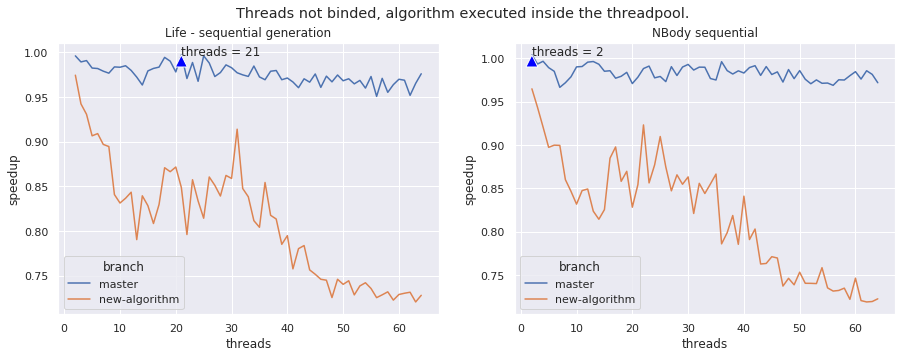

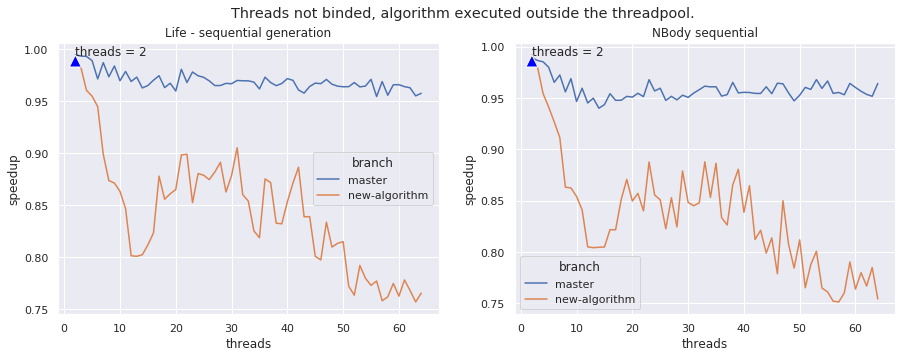

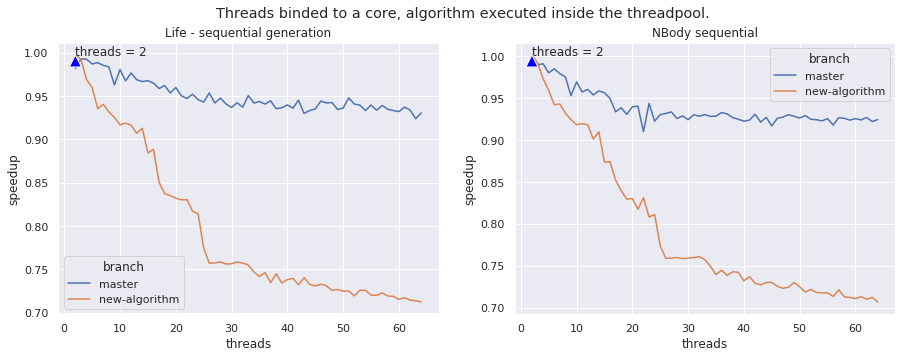

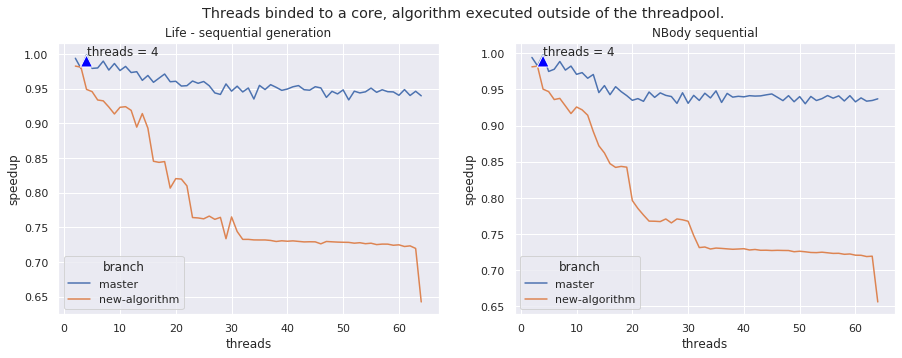

In [3]:
experiments = ['seq-debug', 'seq-debug-outside-tp', 'seq-debug-bind', 'seq-debug-bind-outside-tp']

descriptions = {
    'seq-debug': 'Threads not binded, algorithm executed inside the threadpool.',
    'seq-debug-outside-tp': 'Threads not binded, algorithm executed outside the threadpool.',
    'seq-debug-bind': 'Threads binded to a core, algorithm executed inside the threadpool.',
    'seq-debug-bind-outside-tp': 'Threads binded to a core, algorithm executed outside of the threadpool.'
}

for experiment in experiments:
    master_df, new_algorithm_df = read_data(experiment, 64, 10)
    speedups_master = calculate_speedups(master_df)
    speedups_new_algorithm = calculate_speedups(new_algorithm_df)
    
    master = pd.DataFrame(data=speedups_master)
    master['branch'] = 'master'

    new_algorithm = pd.DataFrame(data=speedups_new_algorithm)
    new_algorithm['branch'] = 'new-algorithm'

    df = pd.concat([master, new_algorithm], ignore_index = True)
    plot_speedup(df, descriptions[experiment])

## Speedup curves varying the sleeping threshold

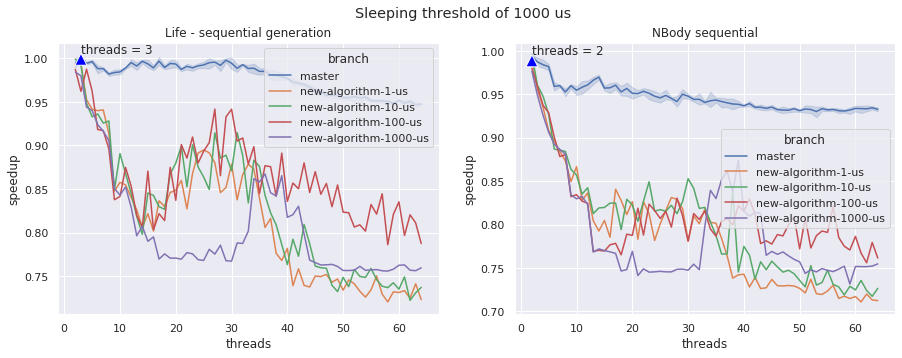

In [4]:
sleeping_thresholds = [1, 10, 100, 1000]

df = None
for st in sleeping_thresholds:
    master_df, new_algorithm_df = read_data('speedup-' + str(st) + 'us', 64, st)
    master_df = master_df[(master_df['name'] == 'Life - sequential generation') | 
                          (master_df['name'] == 'NBody sequential')]
    
    new_algorithm_df = new_algorithm_df[(new_algorithm_df['name'] == 'Life - sequential generation') | 
                          (new_algorithm_df['name'] == 'NBody sequential')]
    
    speedups_master = calculate_speedups(master_df)
    speedups_new_algorithm = calculate_speedups(new_algorithm_df)
    
    master = pd.DataFrame(data=speedups_master)
    master['branch'] = 'master'

    new_algorithm = pd.DataFrame(data=speedups_new_algorithm)
    new_algorithm['branch'] = 'new-algorithm-{}-us'.format(st)

    df = pd.concat([df, master, new_algorithm], ignore_index = True)

plot_speedup(df, 'Sleeping threshold of {} us'.format(st))